# **Association Rule Mining**

## Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules


# Dataset Preparation

## Load the Dataset

In [2]:
anime = pd.read_csv("dataset/anime.csv")
ratings = pd.read_csv("dataset/rating.csv")

## Basic Data Inspection

In [3]:
anime.head()
ratings.head()


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [4]:
anime.info()
print("\n")
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


## Data Cleaning & Filtering

### Remove Unrated Entries
Ratings of -1 mean watched but not rated, may indicate user hasn't finished watching.

In [5]:
ratings = ratings[ratings['rating'] != -1]

### Keep Only “Liked” Anime
Association mining works best with positive interactions.

“Anime that users watched and liked"

In [6]:
ratings = ratings[ratings['rating'] >= 6]

## Merge Anime Names
Convert into readable item names instead of IDs.

In [7]:
data = ratings.merge(
    anime[['anime_id', 'name']],
    on='anime_id'
)

data.head()

,user_id,anime_id,rating,name
0,1,8074,10,Highschool of the Dead
1,1,11617,10,High School DxD
2,1,11757,10,Sword Art Online
3,1,15451,10,High School DxD New
4,2,11771,10,Kuroko no Basket


## Filter Popular Anime

Only count the top 50 anime to ease computation. 

Remove niche animes that are less frequently watched.

In [8]:
popular_anime = data['name'].value_counts().head(100).index
data_filtered = data[data['name'].isin(popular_anime)]

# Create Transaction Dataset

## Group Anime by User
Each user = one transaction

Each anime = one item

Example: User 123 → ["Naruto", "Bleach", "One Piece"]

In [9]:
from itertools import chain

# Convert to list of lists - makes computation faster
transactions = data_filtered.groupby('user_id')['name'].apply(list).tolist()

print("**** Transaction info ****")

print("Transactions:", len(transactions))
print("Avg items per transaction:", sum(len(t) for t in transactions) / len(transactions))
print("Unique items:", len(set(chain.from_iterable(transactions))))


**** Transaction info ****
Transactions: 66256
Avg items per transaction: 19.5523575223376
Unique items: 100


## One-Hot Encoding (TransactionEncoder)

In [10]:
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

df_transactions = pd.DataFrame(te_array, columns=te.columns_)
df_transactions.head()

,Accel World,Akame ga Kill!,Angel Beats!,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.,Another,Ao no Exorcist,Baccano!,Baka to Test to Shoukanjuu,Bakemonogatari,Black Lagoon,...,Tokyo Ghoul,Tokyo Ghoul √A,Tonari no Kaibutsu-kun,Tonari no Totoro,Toradora!,Trigun,Vampire Knight,Yahari Ore no Seishun Love Comedy wa Machigatteiru.,Zero no Tsukaima,Zero no Tsukaima: Futatsuki no Kishi
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,False,True,True,True,False,False,False,False,...,True,True,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Apply Apriori Algorithm

In [11]:
frequent_itemsets = apriori(
    df_transactions,
    min_support=0.02,
    use_colnames=True,
    max_len=2,
    low_memory=True
)

frequent_itemsets.sort_values(by='support', ascending=False).head()

,support,itemsets
24,0.507863,(Death Note)
81,0.374064,(Shingeki no Kyojin)
85,0.366201,(Sword Art Online)
19,0.359318,(Code Geass: Hangyaku no Lelouch)
2,0.346021,(Angel Beats!)


## Generate Association Rules

In [12]:
rules = association_rules(
    frequent_itemsets,
    metric="confidence",
    min_threshold=0.6
)

rules.sort_values(by='lift', ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
408,(Zero no Tsukaima: Futatsuki no Kishi),(Zero no Tsukaima),0.140153,0.179772,0.137346,0.979970,5.451170,1.0,0.112150,40.949643,0.949650,0.752253,0.975580,0.871985
409,(Zero no Tsukaima),(Zero no Tsukaima: Futatsuki no Kishi),0.179772,0.140153,0.137346,0.764000,5.451170,1.0,0.112150,3.643413,0.995520,0.752253,0.725532,0.871985
262,(Fate/Zero 2nd Season),(Fate/Zero),0.154824,0.181765,0.150688,0.973289,5.354666,1.0,0.122547,30.633058,0.962222,0.810587,0.967356,0.901159
263,(Fate/Zero),(Fate/Zero 2nd Season),0.181765,0.154824,0.150688,0.829029,5.354666,1.0,0.122547,4.943399,0.993904,0.810587,0.797710,0.901159
403,(Tokyo Ghoul √A),(Tokyo Ghoul),0.127928,0.217384,0.123898,0.968499,4.455245,1.0,0.096089,24.844391,0.889314,0.559577,0.959749,0.769225


## Filter out prequel - sequel v.v relationships
Association rule mining assumes: Items are independent entities

Sequels violate this assumption:

- Watching Season 2 almost requires watching Season 1

- Lift and confidence become inflated

- Rules become uninformative

### Normalize Anime Titles

In [13]:
import re

def normalize_title(title):
    title = title.lower()
    title = re.sub(r'\(.*?\)', '', title)   # remove parentheses
    title = re.sub(r'[^a-z0-9\s]', '', title)
    title = re.sub(r'\s+', ' ', title).strip()
    return title

### Detect Franchise Overlap

In [14]:
def is_sequel_pair(a, b):
    a_norm = normalize_title(a)
    b_norm = normalize_title(b)
    return a_norm in b_norm or b_norm in a_norm

### Filter Rules

In [15]:
def filter_sequel_rules(rules):
    mask = []
    for _, row in rules.iterrows():
        a = list(row['antecedents'])[0]
        b = list(row['consequents'])[0]
        mask.append(not is_sequel_pair(a, b))
    return rules[mask]

rules_clean = filter_sequel_rules(rules)

## Select Top Rules

In [16]:
top_rules = rules_clean[(rules_clean['lift'] > 1)].sort_values(
    by='confidence',
    ascending=False
)

top_rules.head(50)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
320,(Kiseijuu: Sei no Kakuritsu),(Shingeki no Kyojin),0.148515,0.374064,0.123732,0.833130,2.227238,1.0,0.068178,3.751040,0.647120,0.310225,0.733407,0.581954
6,(Accel World),(Sword Art Online),0.128517,0.366201,0.106466,0.828420,2.262203,1.0,0.059403,3.693908,0.640234,0.274219,0.729284,0.559576
389,(Tokyo Ghoul √A),(Shingeki no Kyojin),0.127928,0.374064,0.105756,0.826687,2.210014,1.0,0.057903,3.611594,0.627831,0.266903,0.723114,0.554705
381,(Tonari no Totoro),(Sen to Chihiro no Kamikakushi),0.155503,0.290193,0.128517,0.826458,2.847965,1.0,0.083391,4.090126,0.768353,0.405187,0.755509,0.634663
338,(Log Horizon),(Sword Art Online),0.139067,0.366201,0.114646,0.824398,2.251218,1.0,0.063720,3.609287,0.645574,0.293497,0.722937,0.568733
108,(Btooom!),(Sword Art Online),0.145949,0.366201,0.118601,0.812616,2.219046,1.0,0.065154,3.382361,0.643235,0.301361,0.704349,0.568242
301,(Howl no Ugoku Shiro),(Sen to Chihiro no Kamikakushi),0.216494,0.290193,0.175275,0.809607,2.789895,1.0,0.112450,3.728113,0.818836,0.528873,0.731768,0.706801
11,(Akame ga Kill!),(Shingeki no Kyojin),0.155261,0.374064,0.125649,0.809274,2.163462,1.0,0.067571,3.281856,0.636621,0.311261,0.695294,0.572588
249,(Death Parade),(Shingeki no Kyojin),0.132305,0.374064,0.106481,0.804814,2.151540,1.0,0.056990,3.206869,0.616826,0.266277,0.688169,0.544737
351,(Nisekoi),(Sword Art Online),0.126539,0.366201,0.101712,0.803793,2.194951,1.0,0.055373,3.230257,0.623278,0.260113,0.690427,0.540770


# Visualization

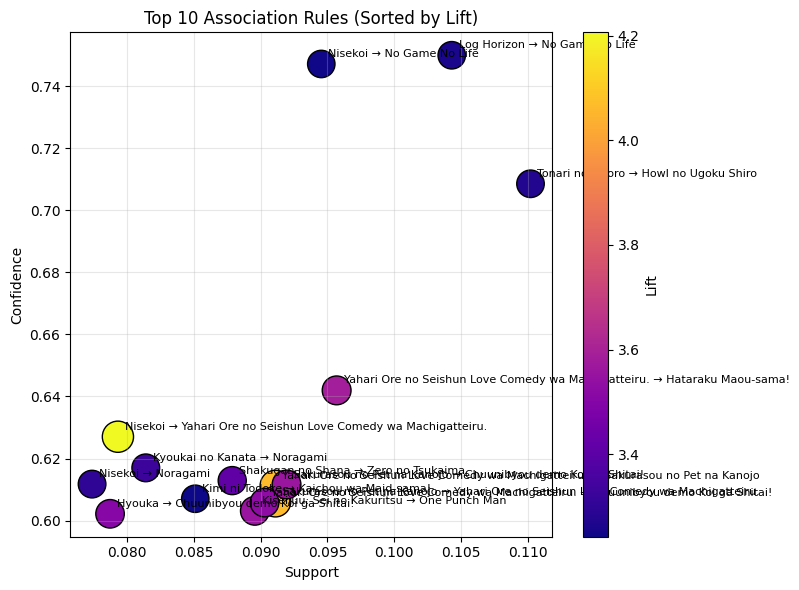

In [ ]:
# Sort rules by lift, then confidence
rules_sorted = rules_clean.sort_values(
    by=['lift', 'confidence'],
    ascending=[False, False]
)

# Select top N rules
top_n = 15
rules_top = rules_sorted.head(top_n)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(
    rules_top['support'],
    rules_top['confidence'],
    s=rules_top['lift'] * 120,
    c=rules_top['lift'],
    cmap='plasma',
    edgecolors='k'
)

# Annotate
for _, row in rules_top.iterrows():
    antecedent = ', '.join(row['antecedents'])
    consequent = ', '.join(row['consequents'])
    plt.annotate(
        f"{antecedent} → {consequent}",
        (row['support'], row['confidence']),
        fontsize=8,
        xytext=(5,5),
        textcoords='offset points'
    )

plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Top 15 Association Rules (Sorted by Lift)')
plt.colorbar(label='Lift')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
